In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
1d input x_i and x_j, alias to x and x' in the paper
for 2d input we should use np.meshgrid or np.mgrid
"""

num_input = 100

x_i = np.linspace(0.0, 1.0, num=num_input)
x_j = np.linspace(0.0, 1.0, num=num_input)

# x_i = np.random.uniform(size=num_input)
# x_j = np.random.uniform(size=num_input)

# display(x_i)
# display(x_j)


In [56]:
"""
activation functions and their derivatives
"""

def relu_kth(x, k):
    return np.maximum(x**k, 0)

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return 1.0 * (x > 0)

def d_relu_kth(x, k):
    return k * x**(k-1) * (x > 0)

# display(relu(f_xi))
# display(d_relu(f_xi))


In [3]:
# take outer product of x_i and x_j to get 100 x 100 matrix
# in the paper sigma was defined entry-wise, but we want to compute the matrix at once
n_0 = 1
beta = 0.01

def calc_sigma_1(x_i, x_j):
    return np.outer(x_i, x_j) / n_0 + beta**2

# display(calc_sigma_1(x_i, x_j))

In [4]:
"""
f(x_i) and f(x_j) follow N(0, cov) where cov is a contatenation of 4 smaller matrices
"""

cov_ii = calc_sigma_1(x_i, x_i)
cov_ij = calc_sigma_1(x_i, x_j)
cov_ji = calc_sigma_1(x_j, x_i)
cov_jj = calc_sigma_1(x_j, x_j)

# cov_ij == cov_ji.T

# concatenate the 4 sigmas

v1 = np.vstack((cov_ii, cov_ji))
v2 = np.vstack((cov_ij, cov_jj))

cov = np.hstack((v1, v2))

display(cov.shape)
# cov == cov.T

In [6]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# is_pos_def(cov)

In [7]:
"""
gaol: approximate expectation using a finite sum and take the mean
now sample Y_i, Y_j from this distribution N(0, cov)
sample and compute outer product first, then take mean
"""
def calc_sigma_2(activation):
    mean = [0] * 2 * num_input
    num_samples = 1000
    sum_N = np.zeros((num_input, num_input))
    for i in range(num_samples):
        sample = np.random.multivariate_normal(mean, cov, size=1)[0]
        f_xi = sample[:num_input]
#         f_xj = sample[num_input:]
        prod = np.outer(activation(f_xi), activation(f_xi))
#         print(prod == prod.T)
        sum_N += np.outer(activation(f_xi), activation(f_xi))

    sigma_2 = (sum_N / num_samples) + beta**2
    
    return sigma_2

#     display(sigma_2)

In [9]:
"""
Compute Theta 1 and 2 using Sigma
"""

THETA_1 = calc_sigma_1(x_i, x_j) # actually make a copy

sigma_2 = calc_sigma_2(relu)
sigma_2_prime = calc_sigma_2(d_relu)

THETA_2 = np.multiply(THETA_1, sigma_2_prime) + sigma_2

In [10]:
display(THETA_1.shape)
display(THETA_2.shape)

(100, 100)

(100, 100)

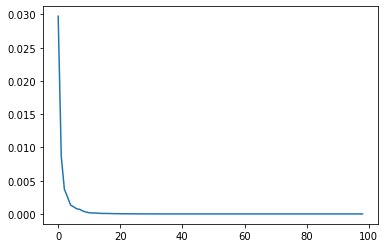

In [12]:
eigenvalues = np.linalg.eigvals(THETA_2)
plt.plot(eigenvalues[1:])

In [36]:
"""
Check results with another approach at
https://papers.nips.cc/paper/2019/file/c4ef9c39b300931b69a36fb3dbb8d60e-Paper.pdf
equation (3)-(5) and page 7 section 3.3
"""

# K(x, x') = <x, x'> E[sig'(<w, x>)sig'(<w, x'>)] + E[sig(<w, x>)sig(<w, x'>)]
# E {w ~ N(0, 1)}
def calc_NTK():
    num_input = 10
    x = np.linspace(-1.0, 1.0, num=num_input)

    num_samples = 1000
    sum_part1 = np.zeros((num_input, num_input))
    sum_part2 = np.zeros((num_input, num_input))

    for i in range(num_samples):
        # sample once from N(0, 1)
        w1, w2 = np.random.normal(loc=0.0, scale=1.0, size=[2, num_input])
        # <w, x> and <w, x'>
        w1x = np.outer(w1, x)
        w2x = np.outer(w2, x)
        # sig'(<w, x>)sig'(<w, x'>)
        part1 = np.multiply(d_relu(w1x), d_relu(w1x))
        # sig(<w, x>)sig(<w, x'>)
        part2 = np.multiply(relu(w2x), relu(w2x))

        sum_part1 += part1
        sum_part2 += part2

    # <x, x'> => x == x'
    xx = np.outer(x, x)
    expectation_1 = (sum_part1 / num_samples)
    expectation_2 = (sum_part2 / num_samples)
    
    # final step; 2 is the nomalization constant in equation (3)
    res = 2 * ( np.multiply(xx, expectation_1) + expectation_2 )
    
    # eigenvalue decay
    eigenvalues = np.linalg.eigvals(res)
    plt.plot(eigenvalues[1:])

In [49]:
w1, w2 = np.random.normal(loc=0.0, scale=1.0, size=[2, 10])

In [50]:
w1

array([-0.72509356, -1.98325789,  0.40387597, -0.27818403, -1.44771146,
       -1.67877352, -0.46182218, -0.28707148, -2.67228325,  0.57363333])

In [51]:
w2

array([ 0.59531139,  0.39949291, -0.27585752,  0.26356441,  1.90519284,
       -2.99591601, -0.40525762,  0.03224626,  2.1595546 ,  0.33941501])

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


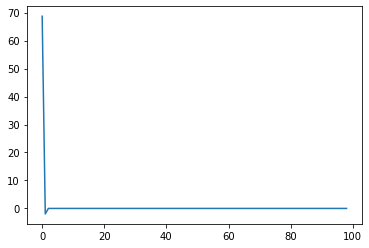

In [37]:
calc_NTK()

In [42]:
"""
analytic solution

u = <x, x'> / ||x|| ||x'||

k(u) = u k_0(u) + k_1(u)

k_0 = 1/pi (pi - arccos(u))
k_1 = 1/pi (u (pi - arccos(u)) + sqrt(1 - u^2))

assuming x == x'
"""

pi = np.pi

xx = np.outer(x, x)

u = xx / (np.linalg.norm(x) ** 2)

k_0 = (1/pi) * (pi - np.arccos(u))
k_1 = (1/pi) * (u * (pi - np.arccos(u)) + np.sqrt(1 - u**2))

K = u * k_0 + k_1

K.shape

(1000, 1000)

In [43]:
res.shape

(1000, 1000)

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


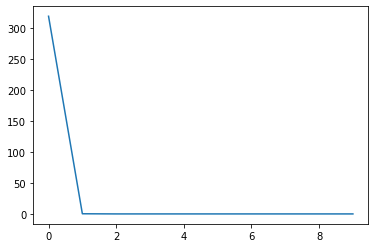

In [48]:
eigenvalues = np.linalg.eigvals(K)
plt.plot(eigenvalues[:10])

In [85]:
def calc_kernel_entry(x, y, num_samples=1000):

    w1, w2 = np.random.normal(loc=0.0, scale=1.0, size=[2, num_samples])

    w1x = w1 * x
    w1y = w1 * y
    sigma_w1x = relu(w1x)
    sigma_w1y = relu(w1y)

    w2x = w2 * x
    w2y = w2 * y
    sigma_w2x = relu(w2x)
    sigma_w2y = relu(w2y)

    expection_1 = sigma_w1x.dot(sigma_w1y) / num_samples
    expection_2 = sigma_w2x.dot(sigma_w2y) / num_samples
    
    return (x * y) * expection_1 + expection_2

In [104]:
num_inputs = 100
x_i = np.linspace(-1.0, 1.0, num=num_inputs)
x_j = np.linspace(-1.0, 1.0, num=num_inputs)

# make kernel
kernel = np.zeros((num_inputs, num_inputs))

for i in range(x_i.shape[0]):
    for j in range(x_j.shape[0]):
        kernel[i][j] = calc_kernel_entry(x_i[i], x_j[j])

In [105]:
kernel.shape

(100, 100)

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


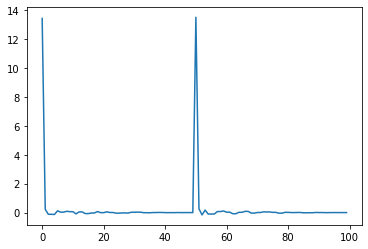

In [106]:
eigenvalues = np.linalg.eigvals(kernel)
plt.plot(eigenvalues)